In [1]:
%matplotlib notebook
import pandas as pd
import re
import sys
from leia import SentimentIntensityAnalyzer 
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [2]:
mean_df = pd.read_csv('Dados/Dados_com_pol')

In [3]:
tabela = mean_df[['data', 'Close', 'text_polaridade', 'Variacao']]
tabela.columns = ['Data', 'Fechamento', 'Polaridade', 'Variação']
tabela[333:337].to_csv('Amostragem dados entrada.csv')

In [4]:
df1 = mean_df['Close']
df2 = mean_df['text_polaridade']
df3 = mean_df['Variacao']

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1_scale = scaler.fit_transform(np.array(df1).reshape(-1,1))
scaler_pol = MinMaxScaler(feature_range=(0,1))
data = np.hstack((df1_scale, scaler_pol.fit_transform(np.array(df2).reshape(-1,1))))

In [6]:
scaler_var = MinMaxScaler(feature_range=(0,1))
df3_scale = scaler_var.fit_transform(np.array(df3).reshape(-1,1))
data2 = np.hstack((df3_scale, scaler_pol.fit_transform(np.array(df2).reshape(-1,1))))

<IPython.core.display.Javascript object>


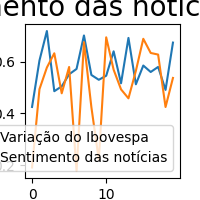

In [7]:
plt.figure(figsize=(2,2))
plt.plot(data2[100: 120])
plt.title('Variação do Índice Ibovespa e sentimento das notícias analisadas (valores normalizados)', fontsize = 20)
plt.xlabel('Índice', fontsize=18)
plt.ylabel('Valor', fontsize=18)
plt.legend(['Variação do Ibovespa', 'Sentimento das notícias'], loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


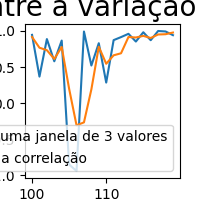

In [8]:
cor = pd.DataFrame(df3_scale).rolling(3).corr(pd.DataFrame(df1_scale))
cor_mean = cor.rolling(3).mean()
plt.figure(figsize=(2,2))
plt.plot(cor[100:120])
plt.plot(cor_mean[100:120])
plt.title('Correlação de Pearson entre a variação do Ibovespa e polaridade', fontsize = 20)
plt.xlabel('Índice', fontsize=18)
plt.ylabel('Correlação', fontsize=18)
plt.legend(['Correlação de uma janela de 3 valores', 'Média móvel da correlação'], loc='lower right')
plt.show()

In [60]:
x_train = []
y_train = []
data_split = 5
all_data = np.split(data, data_split)
analise_sent = 1
split = 0.7

for data_chunk in all_data:
    train_data_len = int(split*len(data_chunk))
    train_data = data_chunk[:train_data_len]    
    
    # Dividindo os dados em x_train_chunk e y_train_chunk4
    x_train_chunk = []
    y_train_chunk = []
    janela = 3

    for i in range(janela, len(train_data)):
        if analise_sent == 0:
            x_train_chunk.append(train_data[i-janela:i])
        elif analise_sent == -1:
            x_train_chunk.append(train_data[i-janela:i, 1])
        else: 
            x_train_chunk.append(train_data[i-janela:i, 0])
        
        y_train_chunk.append(train_data[i, 0])
    x_train.append(np.array(x_train_chunk))
    y_train.append(np.array(y_train_chunk))

In [61]:
# Convertendo o dataset p numpy
x_train, y_train = np.array(x_train), np.array(y_train)
if analise_sent:
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [62]:
# Constuindo o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape=(x_train.shape[-2], x_train.shape[-1])))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=25, activation = 'relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 50)             10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
__________________________________________________

In [63]:
model.compile(optimizer='RMSprop', loss='mean_squared_error')

In [64]:
for x_train_chunk, y_train_chunk in zip(x_train, y_train):
    model.fit(x_train_chunk, y_train_chunk, batch_size=1, epochs=100)

Epoch 1/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 8/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 9/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 11/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 12/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 13/100
90/90 [=================

90/90 [==============================] - 0s 2ms/step - loss: 5.9054e-04
Epoch 100/100
90/90 [==============================] - 0s 2ms/step - loss: 6.3544e-04
Epoch 1/100
90/90 [==============================] - 0s 2ms/step - loss: 8.9227e-04
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 9.3900e-04
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 8.1925e-04
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 8.3359e-04
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 6.9161e-04
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 7.9138e-04
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 6.9546e-04
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 7.2366e-04
Epoch 9/100
90/90 [==============================] - 0s 2ms/step - loss: 6.6058e-04
Epoch 10/100
90/90 [==============================] - 0s 2ms/step - loss: 6.3217e-04
E

90/90 [==============================] - 0s 2ms/step - loss: 5.5802e-04
Epoch 96/100
90/90 [==============================] - 0s 2ms/step - loss: 5.1990e-04
Epoch 97/100
90/90 [==============================] - 0s 2ms/step - loss: 4.9571e-04
Epoch 98/100
90/90 [==============================] - 0s 2ms/step - loss: 5.5178e-04
Epoch 99/100
90/90 [==============================] - 0s 2ms/step - loss: 5.5853e-04
Epoch 100/100
90/90 [==============================] - 0s 2ms/step - loss: 4.8984e-04
Epoch 1/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 9.8841e-04
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 8.8240e-04
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 9.2774e-04
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7/10

90/90 [==============================] - 0s 2ms/step - loss: 9.3510e-04
Epoch 93/100
90/90 [==============================] - 0s 2ms/step - loss: 9.0065e-04
Epoch 94/100
90/90 [==============================] - 0s 2ms/step - loss: 8.9151e-04
Epoch 95/100
90/90 [==============================] - 0s 2ms/step - loss: 7.0726e-04
Epoch 96/100
90/90 [==============================] - 0s 2ms/step - loss: 7.2704e-04
Epoch 97/100
90/90 [==============================] - 0s 2ms/step - loss: 9.0269e-04
Epoch 98/100
90/90 [==============================] - 0s 2ms/step - loss: 9.3357e-04
Epoch 99/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 100/100
90/90 [==============================] - 0s 2ms/step - loss: 9.5627e-04
Epoch 1/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 4/100

90/90 [==============================] - 0s 3ms/step - loss: 8.5905e-04
Epoch 90/100
90/90 [==============================] - 0s 3ms/step - loss: 6.8654e-04
Epoch 91/100
90/90 [==============================] - 0s 3ms/step - loss: 7.7306e-04
Epoch 92/100
90/90 [==============================] - 0s 3ms/step - loss: 7.4477e-04
Epoch 93/100
90/90 [==============================] - 0s 2ms/step - loss: 7.2518e-04
Epoch 94/100
90/90 [==============================] - 0s 2ms/step - loss: 8.3391e-04
Epoch 95/100
90/90 [==============================] - 0s 2ms/step - loss: 8.2648e-04
Epoch 96/100
90/90 [==============================] - 0s 2ms/step - loss: 8.3002e-04
Epoch 97/100
90/90 [==============================] - 0s 2ms/step - loss: 7.2672e-04
Epoch 98/100
90/90 [==============================] - 0s 2ms/step - loss: 8.0549e-04
Epoch 99/100
90/90 [==============================] - 0s 2ms/step - loss: 8.8885e-04
Epoch 100/100
90/90 [==============================] - 0s 2ms/step - loss: 7.3

90/90 [==============================] - 0s 4ms/step - loss: 8.0230e-04
Epoch 86/100
90/90 [==============================] - 0s 2ms/step - loss: 7.7886e-04
Epoch 87/100
90/90 [==============================] - 0s 2ms/step - loss: 6.8490e-04
Epoch 88/100
90/90 [==============================] - 0s 2ms/step - loss: 7.4212e-04
Epoch 89/100
90/90 [==============================] - 0s 3ms/step - loss: 7.9183e-04
Epoch 90/100
90/90 [==============================] - 0s 3ms/step - loss: 7.4735e-04
Epoch 91/100
90/90 [==============================] - 0s 2ms/step - loss: 7.2377e-04
Epoch 92/100
90/90 [==============================] - 0s 2ms/step - loss: 7.1122e-04
Epoch 93/100
90/90 [==============================] - 0s 3ms/step - loss: 7.5308e-04
Epoch 94/100
90/90 [==============================] - 0s 2ms/step - loss: 7.3181e-04
Epoch 95/100
90/90 [==============================] - 0s 2ms/step - loss: 8.2904e-04
Epoch 96/100
90/90 [==============================] - 0s 3ms/step - loss: 7.27

In [65]:
x_test = []
y_test = []
y_mse = []
to_test = np.split(np.array(df1), data_split)

for data_chunk, y_chunk in zip(all_data, to_test):
    test_data = data_chunk[train_data_len-janela:]
    y_test_data = y_chunk[train_data_len-janela:]
    # Dividindo os dados em x_train e y_train
    x_test_chunk = []
    y_test_chunk = []
    y_test_mse = []

    for i in range(janela, len(test_data)):
        if analise_sent == 0:
            x_test_chunk.append(test_data[i-janela:i])
        elif analise_sent == -1:
            x_test_chunk.append(test_data[i-janela:i, 1])
        else: 
            x_test_chunk.append(test_data[i-janela:i, 0])
        
        y_test_chunk.append(y_test_data[i])
        y_test_mse.append(test_data[i,0])
    x_test.append(x_test_chunk)
    y_test.append(y_test_chunk)
    y_mse.append(y_test_mse)

In [66]:
x_test = np.array(x_test)
if analise_sent:
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

In [67]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

<ipython-input-68-557292c57055>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(data_split, figsize=(10,15))


<IPython.core.display.Javascript object>


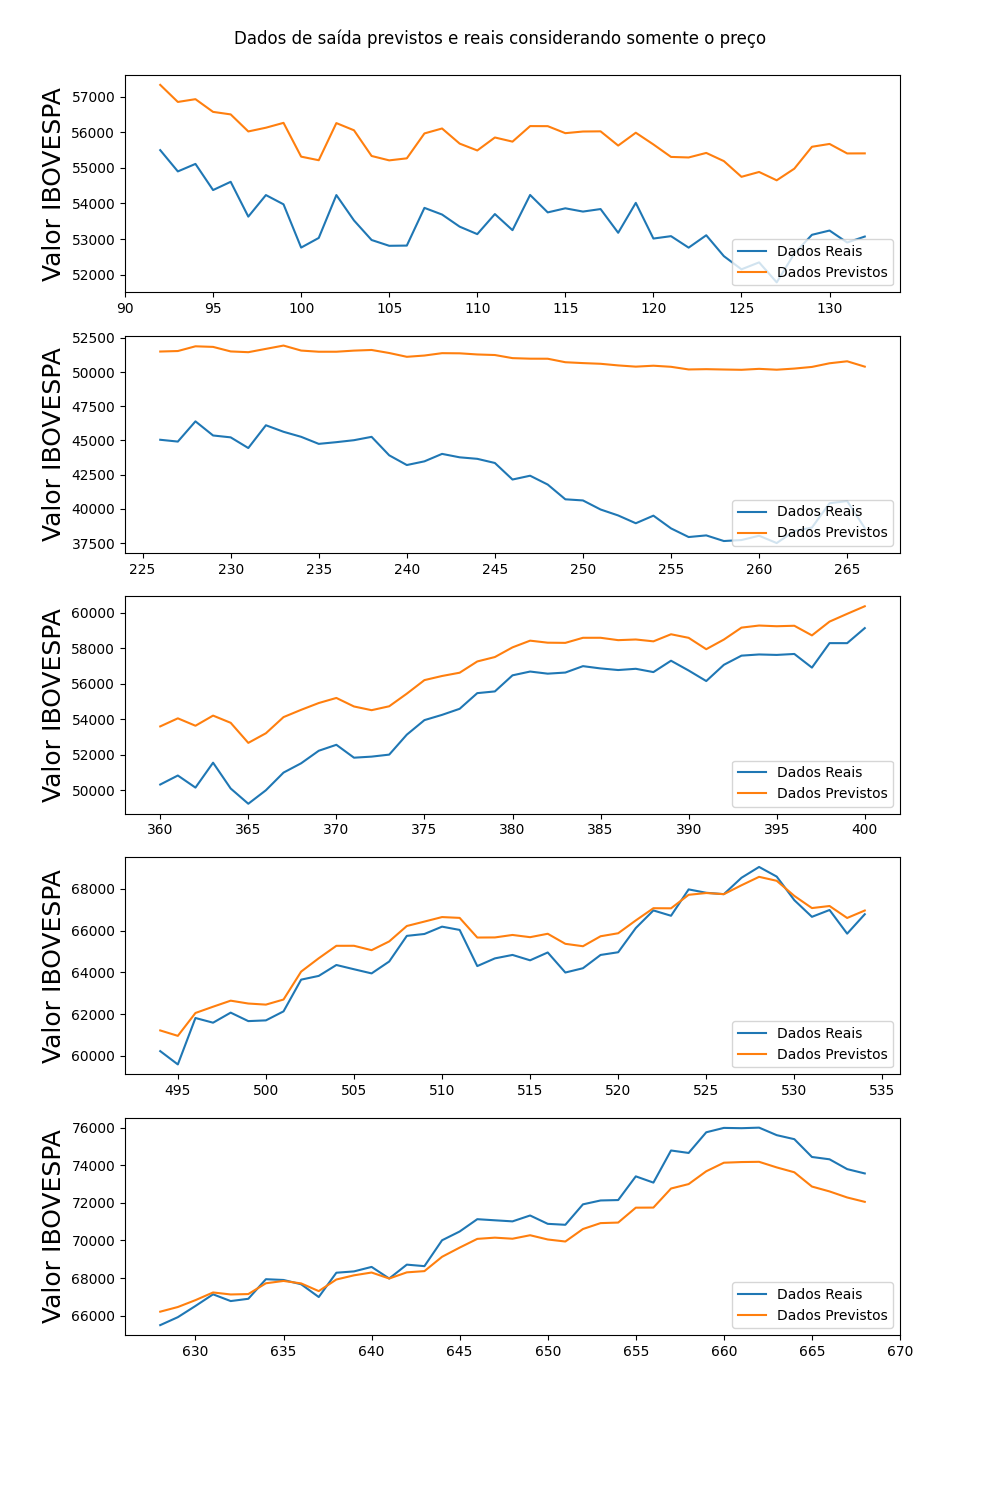

<ipython-input-68-557292c57055>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions.flatten()
<ipython-input-68-557292c57055>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions.flatten()
<ipython-input-68-557292c57055>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

SMAPE para cada rodada: [array([[14.00250464]]), array([[111.92263335]]), array([[11.45843364]]), array([[2.6399053]]), array([[3.37091404]])]
SMAPE médio: 28.67887819143045
MSE para cada rodada: [0.004008990925168608, 0.060014104545147155, 0.003129567773703077, 0.0005219804976955524, 0.0012808653692712297]
MSE média: 0.013791101822197125


<ipython-input-68-557292c57055>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions.flatten()


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

fig, axs = plt.subplots(data_split, figsize=(10,15))
mse = []
mape = []

for i, (x_chunk, y_chunk, y_mse_chunk) in enumerate(zip(x_test, y_test, y_mse)):
    predictions = model.predict(x_chunk) 
    mse.append(mean_squared_error(np.array(y_mse_chunk), predictions))
    mape.append(smape(np.array(y_mse_chunk).reshape(-1, 1), predictions).reshape(-1, 1))
    predictions = scaler.inverse_transform(predictions)
    train = df1[i*len(data_chunk):(i)*len(data_chunk)+train_data_len]
    valid = mean_df[i*len(data_chunk)+train_data_len-1:(i+1)*len(data_chunk)-1]
    valid['Predictions'] = predictions.flatten()
    if data_split == 1:
        axs.set_ylabel('Valor IBOVESPA', fontsize=18)
        axs.plot(valid[['Close', 'Predictions']])
        axs.legend(['Dados Reais','Dados Previstos', 'Dados de Treino'], loc='lower right')
        if analise_sent == 0:
            fig.suptitle('Dados de saída previstos e reais considerando o sentimento das notícias', fontsize = 12)
        elif analise_sent == 1:
            fig.suptitle('Dados de saída previstos e reais considerando somente o preço', fontsize = 12)
        else:
            fig.suptitle('Dados de saída previstos e reais considerando somente o sentimento das notícias', fontsize = 12)
    else:
        axs[i].set_ylabel('Valor IBOVESPA', fontsize=18)
        axs[i].plot(valid[['Close', 'Predictions']])
        axs[i].legend(['Dados Reais','Dados Previstos', 'Dados de Treino'], loc='lower right')
        if analise_sent == 0:
            fig.suptitle('Dados de saída previstos e reais considerando o sentimento das notícias', fontsize = 12)
        elif analise_sent == 1:
            fig.suptitle('Dados de saída previstos e reais considerando somente o preço', fontsize = 12)
        else:
            fig.suptitle('Dados de saída previstos e reais considerando somente o sentimento das notícias', fontsize = 12)

print(f'SMAPE para cada rodada: {mape}\nSMAPE médio: {np.mean(mape)}')
print(f'MSE para cada rodada: {mse}\nMSE média: {np.mean(mse)}')
fig.subplots_adjust(top=0.95)
plt.show()

In [19]:
predictions

array([[[0.35527453],
        [0.37654495],
        [0.37903208]],

       [[0.3597437 ],
        [0.3794417 ],
        [0.3771772 ]],

       [[0.36000583],
        [0.37682623],
        [0.3778352 ]],

       [[0.3571695 ],
        [0.3774309 ],
        [0.37441704]],

       [[0.35950273],
        [0.37447095],
        [0.37455925]],

       [[0.35506207],
        [0.37419945],
        [0.37386635]],

       [[0.35747644],
        [0.37426206],
        [0.372462  ]],

       [[0.35607633],
        [0.37243178],
        [0.36961782]],

       [[0.35505438],
        [0.3697973 ],
        [0.36941534]],

       [[0.35298362],
        [0.36975762],
        [0.36454698]],

       [[0.3542047 ],
        [0.3652143 ],
        [0.37518305]],

       [[0.34882012],
        [0.37569195],
        [0.3792803 ]],

       [[0.36278707],
        [0.38079217],
        [0.3714445 ]],

       [[0.35955617],
        [0.3705335 ],
        [0.36780742]],

       [[0.3509975 ],
        [0.36735806],
    

In [21]:
def signal(close, pred):
    signal = []
    signal.append(1)
    last_op = 0
    for i in range(1,len(close)):
        if pred[i] > close[i]:
            if signal[last_op] == -1:
                last_op = i
                signal.append(1)
            else:
                signal.append(0)
        elif pred[i] < close[i]:
            if signal[last_op] == 1:
                last_op = i
                signal.append(-1)
            else:
                signal.append(0)
        #print(pred[i]>close[i], i, signal, last_op)
        else:
            signal.append(0)
    return signal

In [95]:
signal_val = signal(np.array(valid.Predictions), np.array(valid.Predictions.shift(-1)))

In [96]:
valid['Signal'] = signal_val
df = valid[['data','Signal','Close']]
bt_data = valid[['data', 'High','Low', 'Open', 'Close', 'Volume']]
bt_data.index = pd.to_datetime(bt_data.data)

<ipython-input-96-9f568b4452ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Signal'] = signal_val


In [97]:
orders = df.to_numpy()

<IPython.core.display.Javascript object>


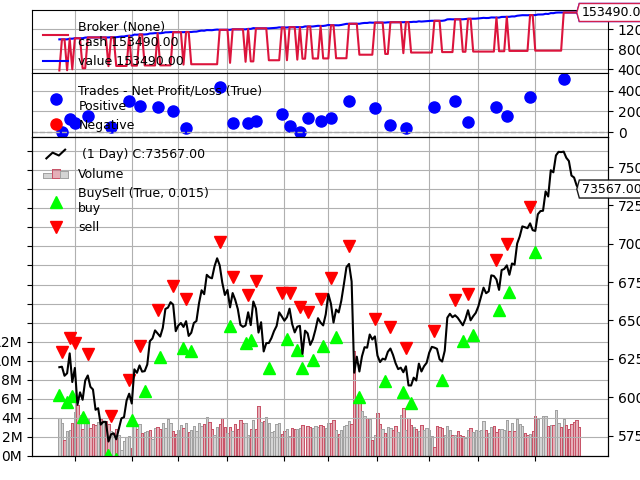

Ending Portfolio Value: 153.48999999999998 %


In [98]:
%matplotlib notebook
import backtrader as bt

start_cash = 100000

cerebro = bt.Cerebro()
cerebro.broker.setcash(start_cash)
feed = bt.feeds.PandasData(dataname=bt_data)
cerebro.adddata(feed)
cerebro.add_order_history(orders, notify=True)
cerebro.run()
cerebro.plot(style = 'line')
print(f'Ending Portfolio Value: {(cerebro.broker.getvalue()/start_cash)*100} %')
plt.show()

In [48]:
(bt_data.Close[-1] - bt_data.Close[0])/bt_data.Close[-1]*100

15.785610395965582